<a href="https://colab.research.google.com/github/mjmousavi97/Graph-Neural-Networks/blob/main/09_Graph_classification/src/graph_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.5 MB/s eta 0:00:00


In [15]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

In [16]:
dataset = TUDataset(root='.', name='PROTEINS').shuffle()

In [17]:
print(f"dataset: {dataset}")
print(f"Number of Graphs: {len(dataset)}")
print(f"Number of Nodes: {dataset[0].num_nodes}")
print(f"Number of Features: {dataset.num_features}")
print(f"Number of Classes: {dataset.num_classes}")

dataset: PROTEINS(1113)
Number of Graphs: 1113
Number of Nodes: 7
Number of Features: 3
Number of Classes: 2


In [18]:
train_dataset = dataset[:int(len(dataset) * 0.8)]
val_dataset = dataset[int(len(dataset) * 0.8):int(len(dataset) * 0.9)]
test_dataset = dataset[int(len(dataset) * 0.9):]

print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of validation graphs: {len(val_dataset)}")
print(f"Number of test graphs: {len(test_dataset)}")

Number of training graphs: 890
Number of validation graphs: 111
Number of test graphs: 112


In [19]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("\nTrain Loader:")
for i, batch in enumerate(train_loader):
    print(f" - batch{i+1}: {batch}")

print("\nValidation Loader:")
for i, batch in enumerate(val_loader):
    print(f" - batch{i+1}: {batch}")

print("\nTest Loader")
for i, batch in enumerate(test_loader):
    print(f" - batch{i+1}: {batch}")


Train Loader:
 - batch1: DataBatch(edge_index=[2, 12364], x=[3091, 3], y=[64], batch=[3091], ptr=[65])
 - batch2: DataBatch(edge_index=[2, 8328], x=[2314, 3], y=[64], batch=[2314], ptr=[65])
 - batch3: DataBatch(edge_index=[2, 10688], x=[2771, 3], y=[64], batch=[2771], ptr=[65])
 - batch4: DataBatch(edge_index=[2, 8200], x=[2208, 3], y=[64], batch=[2208], ptr=[65])
 - batch5: DataBatch(edge_index=[2, 10030], x=[2783, 3], y=[64], batch=[2783], ptr=[65])
 - batch6: DataBatch(edge_index=[2, 7812], x=[2102, 3], y=[64], batch=[2102], ptr=[65])
 - batch7: DataBatch(edge_index=[2, 10108], x=[2789, 3], y=[64], batch=[2789], ptr=[65])
 - batch8: DataBatch(edge_index=[2, 8152], x=[2202, 3], y=[64], batch=[2202], ptr=[65])
 - batch9: DataBatch(edge_index=[2, 10956], x=[2968, 3], y=[64], batch=[2968], ptr=[65])
 - batch10: DataBatch(edge_index=[2, 8588], x=[2365, 3], y=[64], batch=[2365], ptr=[65])
 - batch11: DataBatch(edge_index=[2, 7058], x=[1872, 3], y=[64], batch=[1872], ptr=[65])
 - batch12

## 🧠 Summary: How GIN Works with Multiple Graphs (Batch Processing)

- Each batch contains several graphs.  
  Each graph has multiple nodes with feature vectors and its own edge structure.

- PyTorch Geometric combines all graphs in the batch into **one big graph**:
  - `x` → all node features stacked together  
  - `edge_index` → edges of all graphs with shifted node indices  
  - `batch` → vector indicating which node belongs to which graph

- A single **forward pass** is done for the entire batch (not one per graph).

- Inside each GIN layer:
$$
h_v^{(k)} = \mathrm{MLP}^{(k)}\Big((1+\epsilon)\,h_v^{(k-1)} + \mathrm{AGG}\big(\{h_u^{(k-1)} \mid u \in \mathcal{N}(v)\}\big)\Big)
$$

  - **MLP** = small neural network shared across all nodes and all graphs.  
  - **AGG** = aggregation function (`add`, `mean`, or `max`).  
  - **ε (eps)** controls the weight of the node’s own features (can be learnable if `train_eps=True`).

- 🔁 **Weight sharing**:
  - All nodes in all graphs share the same weights for each GIN layer.  
  - Only node features (`x`) and graph structures (`edge_index`) differ.  
  - During training, gradients from all graphs in the batch are averaged,  
    and the shared weights are updated **once per batch**.

- 🧩 After the GIN layers:
  - Node embeddings are aggregated (via `global_add_pool`, `global_mean_pool`, etc.)  
    to produce one embedding per graph.

- ⚙️ Then a final classifier (usually an MLP) predicts the label for each graph.

- ✅ Summary of updates:
  | Level | Shared Weights? | Updated When? |
  |--------|-----------------|----------------|
  | Nodes within a graph | ✅ Yes | N/A |
  | Graphs within a batch | ✅ Yes | Once per batch |
  | Between batches | ✅ Continue from previous step | After each optimizer step |

**In short:**  
GIN learns a single message-passing function (the same weights) that applies to every node of every graph, combines messages from neighbors, and updates weights only once per batch using the averaged gradient of all graphs.


In [20]:
import torch
from torch import nn
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F

from torch_geometric.nn import GINConv
from torch_geometric.nn import global_add_pool

In [21]:
def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

In [38]:
class GIN(nn.Module):
    def __init__(self, dim_h, dataset):
        super().__init__()

        self.gin1 = GINConv(Sequential(Linear(dataset.num_features, dim_h),
                                       BatchNorm1d(dim_h), ReLU(),
                                       Linear(dim_h, dim_h), ReLU()))
        self.gin2 = GINConv(Sequential(Linear(dim_h, dim_h),
                                       BatchNorm1d(dim_h), ReLU(),
                                       Linear(dim_h, dim_h), ReLU()))
        self.gin3 = GINConv(Sequential(Linear(dim_h, dim_h),
                                       BatchNorm1d(dim_h), ReLU(),
                                       Linear(dim_h, dim_h), ReLU()))

        self.lin1 = Linear(3 * dim_h, dim_h)
        self.lin2 = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x1 = self.gin1(x, edge_index)
        x2 = self.gin2(x1, edge_index)
        x3 = self.gin3(x2, edge_index)

        h1 = global_add_pool(x1, batch)
        h2 = global_add_pool(x2, batch)
        h3 = global_add_pool(x3, batch)

        h = torch.cat([h1, h2, h3], dim=1)
        h = self.lin1(h).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h

    def fit(self, train_loader, val_loader, epochs):
        self.train()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.015)
        criterion = nn.CrossEntropyLoss()

        total_loss_list, acc_list, val_loss_list, val_acc_list = [], [], [], []

        for epoch in range(epochs):
            total_loss, acc, val_loss, val_acc = 0, 0, 0, 0

            for data in train_loader:
                optimizer.zero_grad()
                out = self(data.x, data.edge_index, data.batch)
                loss = criterion(out, data.y)
                total_loss += loss.item() / len(train_loader)
                acc += accuracy(out.argmax(dim=1), data.y) / len(train_loader)
                loss.backward()
                optimizer.step()

            with torch.no_grad():
                for data in val_loader:
                    out = self(data.x, data.edge_index, data.batch)
                    val_loss += criterion(out, data.y).item() / len(val_loader)
                    val_acc += accuracy(out.argmax(dim=1), data.y) / len(val_loader)

            total_loss_list.append(total_loss)
            acc_list.append(acc)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)

            print(f'Epoch {epoch+1}/{epochs}, '
                  f'Train Loss: {total_loss:.4f}, Train Acc: {acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        return total_loss_list, acc_list, val_loss_list, val_acc_list

    @torch.no_grad()
    def test(self, test_loader):
        criterion = nn.CrossEntropyLoss()
        loss, acc = 0, 0
        self.eval()

        for data in test_loader:
            out = self(data.x, data.edge_index, data.batch)
            loss += criterion(out, data.y) / len(test_loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(test_loader)

        return loss, acc

In [39]:
gin = GIN(dim_h=32, dataset=dataset)
total_loss_list, acc_list, val_loss_list, val_acc_list = gin.fit(train_loader, val_loader, epochs=200)

Epoch 1/200, Train Loss: 1.2336, Train Acc: 0.5866, Val Loss: 0.6660, Val Acc: 0.5763
Epoch 2/200, Train Loss: 0.6620, Train Acc: 0.5926, Val Loss: 0.7201, Val Acc: 0.5337
Epoch 3/200, Train Loss: 0.6485, Train Acc: 0.6036, Val Loss: 0.6691, Val Acc: 0.5337
Epoch 4/200, Train Loss: 0.6387, Train Acc: 0.6042, Val Loss: 0.6857, Val Acc: 0.5337
Epoch 5/200, Train Loss: 0.6376, Train Acc: 0.6033, Val Loss: 0.6617, Val Acc: 0.5337
Epoch 6/200, Train Loss: 0.6356, Train Acc: 0.6031, Val Loss: 0.7460, Val Acc: 0.5337
Epoch 7/200, Train Loss: 0.6195, Train Acc: 0.5981, Val Loss: 0.6418, Val Acc: 0.6104
Epoch 8/200, Train Loss: 0.6179, Train Acc: 0.6118, Val Loss: 0.6536, Val Acc: 0.4975
Epoch 9/200, Train Loss: 0.6408, Train Acc: 0.5671, Val Loss: 0.6322, Val Acc: 0.5898
Epoch 10/200, Train Loss: 0.6242, Train Acc: 0.5515, Val Loss: 0.6526, Val Acc: 0.5869
Epoch 11/200, Train Loss: 0.6086, Train Acc: 0.6033, Val Loss: 0.6491, Val Acc: 0.5465
Epoch 12/200, Train Loss: 0.6279, Train Acc: 0.5661,

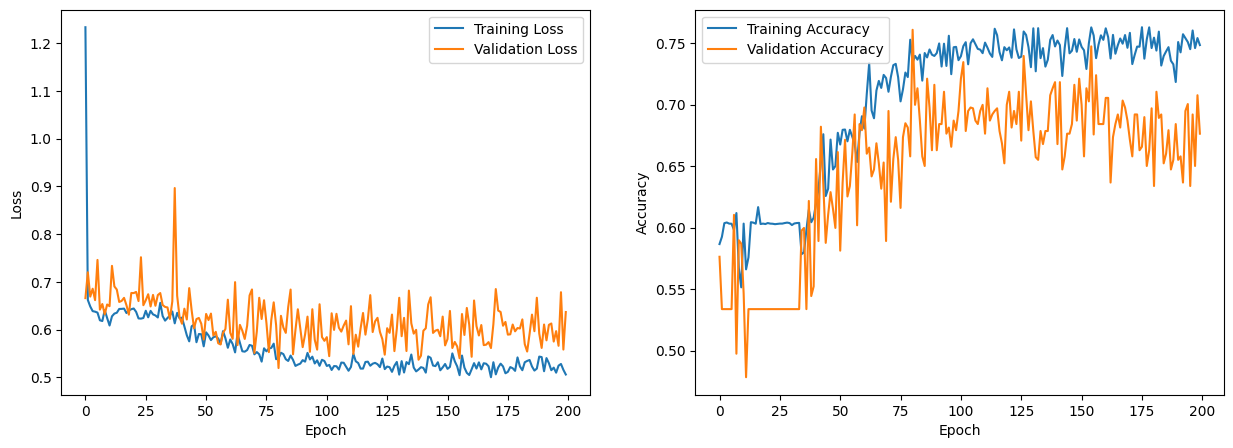

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(total_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()


In [41]:
test_loss, test_acc = gin.test(test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 0.5789, Test Acc: 0.7448


#Now, we are gonna implement a GCN model with a simpleglobal mean pooling(global_mean_pool())

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

def accuracy(pred, y):
    return (pred == y).sum().item() / len(y)

class GCN(nn.Module):
    def __init__(self, dim_h, dataset):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin1 = nn.Linear(3 * dim_h, dim_h)
        self.lin2 = nn.Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x1 = F.relu(self.conv1(x, edge_index))
        x2 = F.relu(self.conv2(x1, edge_index))
        x3 = F.relu(self.conv3(x2, edge_index))
        h1 = global_mean_pool(x1, batch)
        h2 = global_mean_pool(x2, batch)
        h3 = global_mean_pool(x3, batch)
        h = torch.cat([h1, h2, h3], dim=1)
        h = self.lin1(h).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        return h

    def fit(self, train_loader, val_loader, epochs):
        self.train()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        total_loss_list, acc_list, val_loss_list, val_acc_list = [], [], [], []

        for epoch in range(epochs):
            total_loss, acc, val_loss, val_acc = 0, 0, 0, 0
            for data in train_loader:
                optimizer.zero_grad()
                out = self(data.x, data.edge_index, data.batch)
                loss = criterion(out, data.y)
                total_loss += loss.item() / len(train_loader)
                acc += accuracy(out.argmax(dim=1), data.y) / len(train_loader)
                loss.backward()
                optimizer.step()

            with torch.no_grad():
                for data in val_loader:
                    out = self(data.x, data.edge_index, data.batch)
                    val_loss += criterion(out, data.y).item() / len(val_loader)
                    val_acc += accuracy(out.argmax(dim=1), data.y) / len(val_loader)

            total_loss_list.append(total_loss)
            acc_list.append(acc)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            print(f'Epoch {epoch+1}/{epochs}, '
                  f'Train Loss: {total_loss:.4f}, Train Acc: {acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        return total_loss_list, acc_list, val_loss_list, val_acc_list

    @torch.no_grad()
    def test(self, test_loader):
        criterion = nn.CrossEntropyLoss()
        loss, acc = 0, 0
        self.eval()
        for data in test_loader:
            out = self(data.x, data.edge_index, data.batch)
            loss += criterion(out, data.y) / len(test_loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(test_loader)
        return loss, acc


In [44]:
model_gcn = GCN(dim_h=32, dataset=dataset)
total_loss_list, acc_list, val_loss_list, val_acc_list = model_gcn.fit(train_loader, val_loader, epochs=200)

Epoch 1/200, Train Loss: 0.6800, Train Acc: 0.5933, Val Loss: 0.6921, Val Acc: 0.5337
Epoch 2/200, Train Loss: 0.6718, Train Acc: 0.6038, Val Loss: 0.6928, Val Acc: 0.5337
Epoch 3/200, Train Loss: 0.6694, Train Acc: 0.6038, Val Loss: 0.6937, Val Acc: 0.5337
Epoch 4/200, Train Loss: 0.6669, Train Acc: 0.6039, Val Loss: 0.6926, Val Acc: 0.5259
Epoch 5/200, Train Loss: 0.6635, Train Acc: 0.6070, Val Loss: 0.6847, Val Acc: 0.5444
Epoch 6/200, Train Loss: 0.6645, Train Acc: 0.6055, Val Loss: 0.6734, Val Acc: 0.5578
Epoch 7/200, Train Loss: 0.6533, Train Acc: 0.6237, Val Loss: 0.6759, Val Acc: 0.5578
Epoch 8/200, Train Loss: 0.6471, Train Acc: 0.6286, Val Loss: 0.6600, Val Acc: 0.6217
Epoch 9/200, Train Loss: 0.6400, Train Acc: 0.6354, Val Loss: 0.6885, Val Acc: 0.5706
Epoch 10/200, Train Loss: 0.6304, Train Acc: 0.6754, Val Loss: 0.6693, Val Acc: 0.6316
Epoch 11/200, Train Loss: 0.6285, Train Acc: 0.6516, Val Loss: 0.6449, Val Acc: 0.6288
Epoch 12/200, Train Loss: 0.6098, Train Acc: 0.6831,

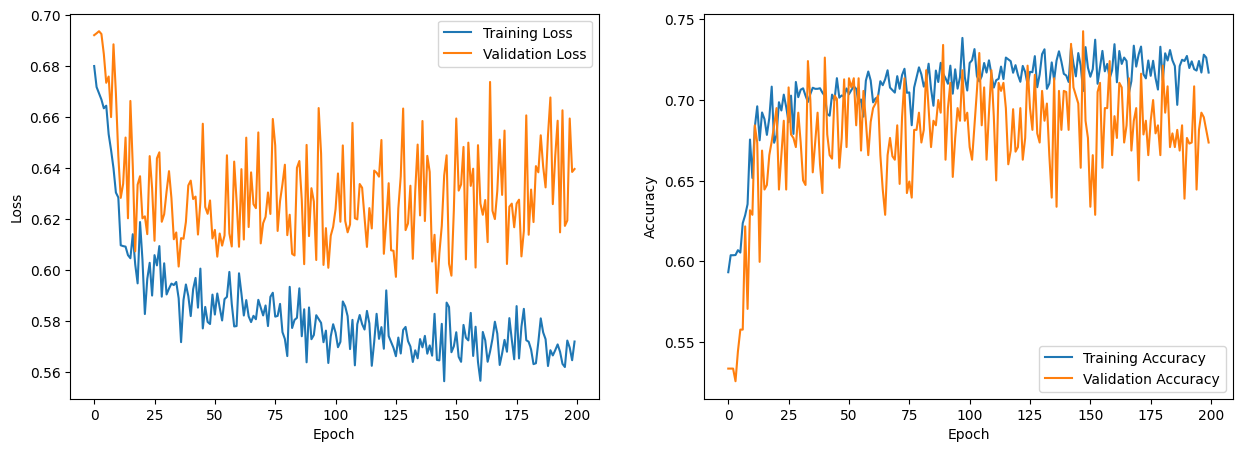

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(total_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [46]:
with torch.no_grad():
    test_loss, test_acc = model_gcn.test(test_loader)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 0.5450, Test Acc: 0.7214
